## Train model with Jing math data


In [1]:
from TrainModel import createImageDataset, showImages
from pathlib import Path
import numpy as np 
from sklearn.model_selection import train_test_split


#Possible set of labels
# """
# ["pegNormal","pegInversion"]
# ["EasyAdd","HardMult"]
# """


In [29]:
dataPath = Path(r"C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiment1-Pilot\UI02\pyprep_edf")
X, y = createImageDataset(dataPath,imageSize=32,frameDuration=1,overlap=0.2,
                          augment_data=False, labels = ["pegNormal","pegInversion"],
                          lstm_format=False, lstm_sequence_length=None,
                         fileNameFormat=1)


# Eyes open-close dataset
# dataPath = Path(r'C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiments3-Data\EyesOpen_closeDataset\edf')
# X, y = createImageDataset(dataPath,imageSize=32,frameDuration=1,overlap=0.2,
#                           augment_data=False, labels = ["EyesClosed","EyesOpen"],
#                           lstm_format=False, lstm_sequence_length=None,
#                          fileNameFormat=2)


file information: Chiho 1 1 EyesClosed
300 frames generated with label  0.0/300Interpolating 60/300Interpolating 89/300Interpolating 144/300Interpolating 173/300Interpolating 204/300Interpolating 291/300
file information: Chiho 1 1 EyesOpen
300 frames generated with label  1.0/300Interpolating 63/300Interpolating 91/300Interpolating 121/300Interpolating 150/300Interpolating 179/300Interpolating 208/300Interpolating 237/300
file information: Chiho 2 1 EyesClosed
300 frames generated with label  0.0/300Interpolating 89/300Interpolating 119/300Interpolating 148/300Interpolating 177/300Interpolating 205/300Interpolating 234/300Interpolating 264/300
file information: Chiho 2 2 EyesOpen
300 frames generated with label  1.0/300Interpolating 63/300Interpolating 93/300Interpolating 184/300Interpolating 211/300Interpolating 241/300Interpolating 264/300Interpolating 293/300
file information: Chiho 4 1 EyesClosed
300 frames generated with label  0.0/300Interpolating 63/300Interpolating 92/300Inter

In [4]:
dataPath = Path(r"C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiments3-Data\ArithmeticCalibrationProcedure\edf")
X_arith, y_arith = createImageDataset(dataPath,imageSize=64,frameDuration=1,overlap=0.2,
                          image_format=False, augment_data=False, labels = ["EasyAdd","HardMult"],
                          lstm_format=False, lstm_sequence_length=None,
                         fileNameFormat=2)


file information: UJing 1 1 EasyAdd
file information: UJing 1 2 HardMult
file information: UJing 1 3 EasyAdd
file information: UJing 1 4 HardMult
file information: UJing 1 5 EasyAdd
file information: UJing 1 6 HardMult
file information: UJing 1 7 EasyAdd
file information: UJing 1 8 HardMult
file information: UJing 1 9 EasyAdd
file information: UJing 1 10 HardMult
file information: UJing 1 11 EasyAdd
file information: UJing 1 12 HardMult
file information: UJing 2 1 EasyAdd
file information: UJing 2 2 HardMult
file information: UJing 2 3 EasyAdd
file information: UJing 2 4 HardMult
file information: UJing 2 5 EasyAdd
file information: UJing 2 6 HardMult
file information: UJing 2 7 EasyAdd
file information: UJing 2 8 HardMult
file information: UJing 2 9 EasyAdd
file information: UJing 2 10 HardMult
file information: UJing 2 11 EasyAdd
file information: UJing 2 12 HardMult
file information: UJing 3 1 EasyAdd
file information: UJing 3 2 HardMult
file information: UJing 3 3 EasyAdd
file info

In [5]:
print("Arithmetic dataset size", )
print(X_arith.shape, y_arith.shape)

# print("Inversion dataset size", )
# print(X.shape, y.shape)
# showImages(X,y)

# X.max()

Arithmetic dataset size
(2352, 90) (2352,)


## Create model


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed, Input, BatchNormalization, Softmax
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model


def createConvModel(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
    model.add(Dropout(rate=0.3))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Dropout(rate=0.3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

def createLstmModel(input_shape,num_classes, lstmLayers=2, lstmOutputSize=4.0,
                  isBidirectional=1.0, inputLayerNeurons=64, inputLayerDropout=0.25):

    dropoutRate = 0.45
    
    lstmLayers = int(lstmLayers)
    lstmOutputSize =int(lstmOutputSize)
    isBidirectional =int(isBidirectional)

    # Input layer
    networkInput = Input(shape=input_shape)
    dropout1 = Dropout(rate=inputLayerDropout)(networkInput)

    # First Hidden layer
    hidden1 = Dense(inputLayerNeurons, activation='relu')(dropout1)
    dropout2 = Dropout(rate=dropoutRate)(hidden1)
    batchNorm1 = BatchNormalization()(dropout2)

    out = batchNorm1
    for i in range(1, lstmLayers+1):
        retSeq = False if i == lstmLayers else True
        lstmLayer = LSTM(lstmOutputSize, stateful=False, return_sequences=retSeq,
                         dropout=dropoutRate, kernel_regularizer=regularizers.l2(0.05))
        if isBidirectional:
            out = Bidirectional(lstmLayer, merge_mode='concat')(out)
        else:
            out = lstmLayer(out)

    hidden3 = Dense(num_classes, activation='linear')(out)
    networkOutput = Softmax()(hidden3)

    model1 = Model(inputs=networkInput, outputs=networkOutput)
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model1

def createConvLstmModel(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=(input_shape)))
#     model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same')))
# #     model.add(Dropout(rate=0.3))
#     model.add(TimeDistributed(Activation('relu')))
#     model.add(Dropout(rate=0.3))
    model.add(TimeDistributed(Conv2D(16, (3, 3))))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(45)))
    model.add(TimeDistributed(Activation('relu')))
    #model.add(Dropout(0.5))
    
    #LSTM layer
    model.add(Bidirectional(LSTM(20, stateful=False, dropout=0.35)))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model
    

In [3]:
#Model summary
testModel = createConvModel((32,32,3),2)
testModel.summary()

testModel = createLstmModel((3, 90),2)
testModel.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0

## Train convolutional network


In [31]:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

print(y_train.shape)

img_rows, img_cols = 32, 32

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

(3360,)
x_train shape: (3360, 32, 32, 3)
x_test shape: (840, 32, 32, 3)
3360 train samples
840 test samples


In [32]:
## Get dataset statistics
print(x_train.shape)
print("Global statistics")
print(x_train.mean())
print(x_train.std())
print("Statistics per color")
print(x_train.mean(axis=(0, 1,2)))
print(x_train.std(axis=(0,1,2)))

##Normalize the dataset

##No normalization -- Seems to yield the best results 
# x_train_2 = x_train
# x_test_2 = x_test

##Method 1: Normalize with global mean and std
global_mean = x_train.mean(); global_std = x_train.std();
x_train_2 = (x_train - global_mean)/global_std;
x_test_2 = (x_test - global_mean)/global_std;

##Method 2: Normalize each color channel independently (e.g normalize the red channel with red mean accross all samples)
# color_mean = x_train.mean(axis=(0, 1,2)); color_std = x_train.std(axis=(0, 1,2));
# color_mean = np.expand_dims(color_mean,axis=(0,1,2))
# x_train_2 = (x_train - color_mean)/color_std;
# x_test_2 = (x_test - color_mean)/color_std;


##Debug
x_train_2.std()

(3360, 32, 32, 3)
Global statistics
0.20303775
0.19670053
Statistics per color
[0.18281205 0.17406805 0.25223285]
[0.17917745 0.17015097 0.22660296]


0.9999998

In [35]:
batch_size = 128
num_classes = 2
epochs = 400
img_size = 32
input_shape = (img_size, img_size, 3)

# convert class vectors to binary class matrices
y_train_2 = keras.utils.to_categorical(y_train, num_classes)
y_test_2 = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)
print(x_train.shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

model = createModel(input_shape, num_classes)

history = model.fit(x_train_2, y_train_2,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_2, y_test_2),
          shuffle=True)

(3360,)
(3360, 32, 32, 3)
Train on 3360 samples, validate on 840 samples
Epoch 1/400
3360/3360 [==============================] - 3s 818us/sample - loss: 0.5991 - accuracy: 0.6625 - val_loss: 0.5982 - val_accuracy: 0.7012
Epoch 2/400
3360/3360 [==============================] - 0s 98us/sample - loss: 0.5584 - accuracy: 0.6914 - val_loss: 0.5723 - val_accuracy: 0.6917
Epoch 3/400
3360/3360 [==============================] - 0s 95us/sample - loss: 0.5421 - accuracy: 0.7030 - val_loss: 0.5700 - val_accuracy: 0.7048
Epoch 4/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.5290 - accuracy: 0.7164 - val_loss: 0.5388 - val_accuracy: 0.7143
Epoch 5/400
3360/3360 [==============================] - 0s 98us/sample - loss: 0.5173 - accuracy: 0.7202 - val_loss: 0.5648 - val_accuracy: 0.7536
Epoch 6/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.5126 - accuracy: 0.7262 - val_loss: 0.5368 - val_accuracy: 0.7440
Epoch 7/400
3360/3360 [===============

Epoch 110/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.3045 - accuracy: 0.8792 - val_loss: 0.3404 - val_accuracy: 0.8738
Epoch 111/400
3360/3360 [==============================] - 0s 96us/sample - loss: 0.2916 - accuracy: 0.8830 - val_loss: 0.3225 - val_accuracy: 0.8786
Epoch 112/400
3360/3360 [==============================] - 0s 97us/sample - loss: 0.2970 - accuracy: 0.8836 - val_loss: 0.3428 - val_accuracy: 0.8690
Epoch 113/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.2984 - accuracy: 0.8821 - val_loss: 0.3815 - val_accuracy: 0.8179
Epoch 114/400
3360/3360 [==============================] - 0s 100us/sample - loss: 0.2916 - accuracy: 0.8866 - val_loss: 0.3628 - val_accuracy: 0.8476
Epoch 115/400
3360/3360 [==============================] - 0s 98us/sample - loss: 0.2963 - accuracy: 0.8869 - val_loss: 0.3691 - val_accuracy: 0.8262
Epoch 116/400
3360/3360 [==============================] - 0s 97us/sample - loss: 0.2961 - accuracy

3360/3360 [==============================] - 0s 98us/sample - loss: 0.2248 - accuracy: 0.9086 - val_loss: 0.2944 - val_accuracy: 0.8786
Epoch 219/400
3360/3360 [==============================] - 0s 97us/sample - loss: 0.2314 - accuracy: 0.9107 - val_loss: 0.3238 - val_accuracy: 0.8524
Epoch 220/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.2408 - accuracy: 0.9080 - val_loss: 0.2945 - val_accuracy: 0.8869
Epoch 221/400
3360/3360 [==============================] - 0s 98us/sample - loss: 0.2189 - accuracy: 0.9143 - val_loss: 0.3000 - val_accuracy: 0.8750
Epoch 222/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.2373 - accuracy: 0.9071 - val_loss: 0.2884 - val_accuracy: 0.8881
Epoch 223/400
3360/3360 [==============================] - 0s 98us/sample - loss: 0.2219 - accuracy: 0.9155 - val_loss: 0.2908 - val_accuracy: 0.8881
Epoch 224/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.2292 - accuracy: 0.9089 - val_

3360/3360 [==============================] - 0s 100us/sample - loss: 0.1812 - accuracy: 0.9315 - val_loss: 0.3223 - val_accuracy: 0.8440
Epoch 327/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.1850 - accuracy: 0.9259 - val_loss: 0.3070 - val_accuracy: 0.8583
Epoch 328/400
3360/3360 [==============================] - 0s 101us/sample - loss: 0.1835 - accuracy: 0.9298 - val_loss: 0.2858 - val_accuracy: 0.8738
Epoch 329/400
3360/3360 [==============================] - 0s 100us/sample - loss: 0.1880 - accuracy: 0.9327 - val_loss: 0.2726 - val_accuracy: 0.8929
Epoch 330/400
3360/3360 [==============================] - 0s 101us/sample - loss: 0.1841 - accuracy: 0.9312 - val_loss: 0.2613 - val_accuracy: 0.8976
Epoch 331/400
3360/3360 [==============================] - 0s 97us/sample - loss: 0.1836 - accuracy: 0.9315 - val_loss: 0.3157 - val_accuracy: 0.8548
Epoch 332/400
3360/3360 [==============================] - 0s 99us/sample - loss: 0.1791 - accuracy: 0.9327 - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


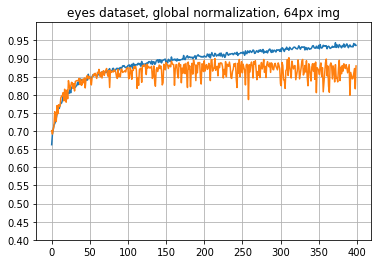

In [36]:
import matplotlib.pyplot as plt

print(history.history.keys())
fig, ax = plt.subplots(1)

ax.set_title("eyes dataset, global normalization, 64px img")
ax.set_ylim((0.4,1))
ax.set_yticks(np.arange(0.4,1,0.05))
ax.grid()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])

## Train Convolutional LSTM model

### Loading arithmetic calibration data

In [3]:
image_size = 32
frame_length = 1
sequence_length = 6
overlap = 0.5
num_classes = 2

In [4]:
dataPath = Path(r"C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiments3-Data\ArithmeticCalibrationProcedure\edf")
X_arith_seq, y_arith_seq = createImageDataset(dataPath,imageSize=image_size,frameDuration=frame_length,overlap=overlap,
                           augment_data=False, labels = ["EasyAdd","HardMult"],
                           lstm_format=True, lstm_sequence_length=sequence_length,
                           fileNameFormat=2)



file information: UJing 1 1 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 2 HardMult
60 frames generated with label  1.0/60
file information: UJing 1 3 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 4 HardMult
60 frames generated with label  1.0/60
file information: UJing 1 5 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 6 HardMult
60 frames generated with label  1.0/60Interpolating 59/60
file information: UJing 1 7 EasyAdd
Interpolating 60/60Interpolating 30/6060 frames generated with label  0.0
file information: UJing 1 8 HardMult
60 frames generated with label  1.0/60
file information: UJing 1 9 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 10 HardMult
60 frames generated with label  1.0/60Interpolating 59/60
file information: UJing 1 11 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 12 HardMult
60 frames generated with label  1.0/60
file information: 

In [4]:
# dataPath = Path(r"C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiment1-Pilot\UI02\pyprep_edf")
# X_inver_seq, y_inver_seq = createImageDataset(dataPath,imageSize=32,frameDuration=1,overlap=0.2,
#                           augment_data=False, labels = ["pegNormal","pegInversion"],
#                           lstm_format=False, lstm_sequence_length=None,
#                          fileNameFormat=1)   
print(X.shape)
print(y.shape)

file information: UI02 1 1 pegNormal
375 frames generated with label  0.0/375Interpolating 60/375Interpolating 92/375Interpolating 123/375Interpolating 153/375Interpolating 184/375Interpolating 216/375Interpolating 244/375Interpolating 275/375Interpolating 306/375Interpolating 337/375Interpolating 369/375
file information: UI02 1 2 pegInversion
375 frames generated with label  1.0/375Interpolating 67/375Interpolating 97/375Interpolating 129/375Interpolating 161/375Interpolating 193/375Interpolating 224/375Interpolating 255/375Interpolating 287/375Interpolating 316/375Interpolating 347/375
file information: UI02 1 3 pegNormal
375 frames generated with label  0.0/375Interpolating 64/375Interpolating 96/375Interpolating 129/375Interpolating 161/375Interpolating 193/375Interpolating 224/375Interpolating 254/375Interpolating 285/375Interpolating 313/375Interpolating 343/375Interpolating 374/375
file information: UI02 1 4 pegInversion
375 frames generated with label  1.0/375Interpolating 64/

KeyboardInterrupt: 

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_arith_seq, y_arith_seq, test_size=0.20,shuffle=True)

In [6]:
##Normalize the dataset

##No normalization -- Seems to yield the best results 
# x_train_2 = x_train
# x_test_2 = x_test

##Global frame/time normalization
global_mean = x_train.mean(); global_std = x_train.std();
x_train_2 = (x_train - global_mean)/global_std;
x_test_2 = (x_test - global_mean)/global_std;

## convert class vectors to binary class matrices
y_train_2 = keras.utils.to_categorical(y_train, num_classes)
y_test_2 = keras.utils.to_categorical(y_test, num_classes)

x_train_2 = x_train_2.astype('float32')
x_test_2 = x_test_2.astype('float32')

print(y_train.shape)
print(x_train.shape)

(451,)
(451, 6, 32, 32, 3)


In [10]:

##Training
batch_size = 128
num_classes = 2
epochs = 500
input_shape = (sequence_length, image_size,image_size,3)
model = createConvLstmModel(input_shape, num_classes)

history = model.fit(x_train_2, y_train_2,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_2, y_test_2),
          shuffle=True)

Train on 451 samples, validate on 113 samples
Epoch 1/500
451/451 [==============================] - 7s 15ms/sample - loss: 0.7200 - accuracy: 0.4989 - val_loss: 0.6726 - val_accuracy: 0.5487
Epoch 2/500
451/451 [==============================] - 0s 196us/sample - loss: 0.6766 - accuracy: 0.5521 - val_loss: 0.6629 - val_accuracy: 0.6283
Epoch 3/500
451/451 [==============================] - 0s 198us/sample - loss: 0.6656 - accuracy: 0.5831 - val_loss: 0.6551 - val_accuracy: 0.6106
Epoch 4/500
451/451 [==============================] - 0s 190us/sample - loss: 0.6544 - accuracy: 0.6120 - val_loss: 0.6814 - val_accuracy: 0.5664
Epoch 5/500
451/451 [==============================] - 0s 188us/sample - loss: 0.6576 - accuracy: 0.6341 - val_loss: 0.6573 - val_accuracy: 0.6106
Epoch 6/500
451/451 [==============================] - 0s 188us/sample - loss: 0.6449 - accuracy: 0.6253 - val_loss: 0.6491 - val_accuracy: 0.6283
Epoch 7/500
451/451 [==============================] - 0s 193us/sample - 

451/451 [==============================] - 0s 186us/sample - loss: 0.5524 - accuracy: 0.7140 - val_loss: 0.6260 - val_accuracy: 0.6991
Epoch 57/500
451/451 [==============================] - 0s 183us/sample - loss: 0.5309 - accuracy: 0.7716 - val_loss: 0.6776 - val_accuracy: 0.6283
Epoch 58/500
451/451 [==============================] - 0s 184us/sample - loss: 0.5522 - accuracy: 0.7118 - val_loss: 0.6246 - val_accuracy: 0.6903
Epoch 59/500
451/451 [==============================] - 0s 182us/sample - loss: 0.5197 - accuracy: 0.7428 - val_loss: 0.6160 - val_accuracy: 0.6814
Epoch 60/500
451/451 [==============================] - 0s 177us/sample - loss: 0.5359 - accuracy: 0.7428 - val_loss: 0.6293 - val_accuracy: 0.6726
Epoch 61/500
451/451 [==============================] - 0s 180us/sample - loss: 0.5691 - accuracy: 0.7140 - val_loss: 0.6173 - val_accuracy: 0.6637
Epoch 62/500
451/451 [==============================] - 0s 182us/sample - loss: 0.5167 - accuracy: 0.7627 - val_loss: 0.6148 

451/451 [==============================] - 0s 183us/sample - loss: 0.4751 - accuracy: 0.7738 - val_loss: 0.7286 - val_accuracy: 0.6195
Epoch 112/500
451/451 [==============================] - 0s 183us/sample - loss: 0.4879 - accuracy: 0.7583 - val_loss: 0.6583 - val_accuracy: 0.6372
Epoch 113/500
451/451 [==============================] - 0s 182us/sample - loss: 0.4758 - accuracy: 0.7605 - val_loss: 0.6399 - val_accuracy: 0.6549
Epoch 114/500
451/451 [==============================] - 0s 182us/sample - loss: 0.4602 - accuracy: 0.7805 - val_loss: 0.6241 - val_accuracy: 0.6814
Epoch 115/500
451/451 [==============================] - 0s 184us/sample - loss: 0.4535 - accuracy: 0.8160 - val_loss: 0.7967 - val_accuracy: 0.6106
Epoch 116/500
451/451 [==============================] - 0s 184us/sample - loss: 0.4796 - accuracy: 0.7916 - val_loss: 0.6260 - val_accuracy: 0.6637
Epoch 117/500
451/451 [==============================] - 0s 180us/sample - loss: 0.4632 - accuracy: 0.7783 - val_loss: 0

451/451 [==============================] - 0s 180us/sample - loss: 0.4304 - accuracy: 0.7916 - val_loss: 0.6448 - val_accuracy: 0.6637
Epoch 167/500
451/451 [==============================] - 0s 182us/sample - loss: 0.4006 - accuracy: 0.8337 - val_loss: 0.6526 - val_accuracy: 0.6460
Epoch 168/500
451/451 [==============================] - 0s 177us/sample - loss: 0.4028 - accuracy: 0.8293 - val_loss: 0.6560 - val_accuracy: 0.6549
Epoch 169/500
451/451 [==============================] - 0s 179us/sample - loss: 0.4017 - accuracy: 0.8226 - val_loss: 0.6518 - val_accuracy: 0.6549
Epoch 170/500
451/451 [==============================] - 0s 176us/sample - loss: 0.3881 - accuracy: 0.8448 - val_loss: 0.6403 - val_accuracy: 0.6726
Epoch 171/500
451/451 [==============================] - 0s 180us/sample - loss: 0.4075 - accuracy: 0.8004 - val_loss: 0.6601 - val_accuracy: 0.6637
Epoch 172/500
451/451 [==============================] - 0s 182us/sample - loss: 0.3968 - accuracy: 0.8271 - val_loss: 0

451/451 [==============================] - 0s 180us/sample - loss: 0.3287 - accuracy: 0.8625 - val_loss: 0.6674 - val_accuracy: 0.6991
Epoch 222/500
451/451 [==============================] - 0s 182us/sample - loss: 0.3175 - accuracy: 0.8625 - val_loss: 0.6657 - val_accuracy: 0.6814
Epoch 223/500
451/451 [==============================] - 0s 183us/sample - loss: 0.3252 - accuracy: 0.8891 - val_loss: 0.7663 - val_accuracy: 0.6106
Epoch 224/500
451/451 [==============================] - 0s 182us/sample - loss: 0.3902 - accuracy: 0.8293 - val_loss: 0.6656 - val_accuracy: 0.6549
Epoch 225/500
451/451 [==============================] - 0s 186us/sample - loss: 0.3094 - accuracy: 0.8780 - val_loss: 0.6960 - val_accuracy: 0.6637
Epoch 226/500
451/451 [==============================] - 0s 184us/sample - loss: 0.3532 - accuracy: 0.8426 - val_loss: 0.6635 - val_accuracy: 0.6903
Epoch 227/500
451/451 [==============================] - 0s 177us/sample - loss: 0.3215 - accuracy: 0.8803 - val_loss: 0

451/451 [==============================] - 0s 188us/sample - loss: 0.2673 - accuracy: 0.9069 - val_loss: 0.7395 - val_accuracy: 0.6637
Epoch 277/500
451/451 [==============================] - 0s 184us/sample - loss: 0.2878 - accuracy: 0.8869 - val_loss: 0.7866 - val_accuracy: 0.6549
Epoch 278/500
451/451 [==============================] - 0s 182us/sample - loss: 0.3055 - accuracy: 0.8625 - val_loss: 0.7576 - val_accuracy: 0.6637
Epoch 279/500
451/451 [==============================] - 0s 179us/sample - loss: 0.2913 - accuracy: 0.8803 - val_loss: 0.7467 - val_accuracy: 0.6637
Epoch 280/500
451/451 [==============================] - 0s 184us/sample - loss: 0.2944 - accuracy: 0.8692 - val_loss: 0.7114 - val_accuracy: 0.6814
Epoch 281/500
451/451 [==============================] - 0s 184us/sample - loss: 0.3350 - accuracy: 0.8248 - val_loss: 0.7537 - val_accuracy: 0.6549
Epoch 282/500
451/451 [==============================] - 0s 186us/sample - loss: 0.2975 - accuracy: 0.8803 - val_loss: 0

451/451 [==============================] - 0s 177us/sample - loss: 0.2749 - accuracy: 0.8780 - val_loss: 0.7254 - val_accuracy: 0.6991
Epoch 332/500
451/451 [==============================] - 0s 180us/sample - loss: 0.2048 - accuracy: 0.9313 - val_loss: 0.7448 - val_accuracy: 0.6726
Epoch 333/500
451/451 [==============================] - 0s 182us/sample - loss: 0.2349 - accuracy: 0.9157 - val_loss: 0.7913 - val_accuracy: 0.7257
Epoch 334/500
451/451 [==============================] - 0s 189us/sample - loss: 0.2133 - accuracy: 0.9246 - val_loss: 0.7542 - val_accuracy: 0.6814
Epoch 335/500
451/451 [==============================] - 0s 184us/sample - loss: 0.2019 - accuracy: 0.9290 - val_loss: 0.7411 - val_accuracy: 0.6726
Epoch 336/500
451/451 [==============================] - 0s 182us/sample - loss: 0.2341 - accuracy: 0.9047 - val_loss: 0.8763 - val_accuracy: 0.6637
Epoch 337/500
451/451 [==============================] - 0s 180us/sample - loss: 0.3011 - accuracy: 0.8581 - val_loss: 0

451/451 [==============================] - 0s 186us/sample - loss: 0.2081 - accuracy: 0.9246 - val_loss: 0.8169 - val_accuracy: 0.6549
Epoch 387/500
451/451 [==============================] - 0s 182us/sample - loss: 0.1890 - accuracy: 0.9379 - val_loss: 0.8616 - val_accuracy: 0.6814
Epoch 388/500
451/451 [==============================] - 0s 180us/sample - loss: 0.1712 - accuracy: 0.9401 - val_loss: 0.8079 - val_accuracy: 0.6726
Epoch 389/500
451/451 [==============================] - 0s 180us/sample - loss: 0.1667 - accuracy: 0.9446 - val_loss: 0.8247 - val_accuracy: 0.6903
Epoch 390/500
451/451 [==============================] - 0s 184us/sample - loss: 0.1778 - accuracy: 0.9357 - val_loss: 0.9090 - val_accuracy: 0.6991
Epoch 391/500
451/451 [==============================] - 0s 182us/sample - loss: 0.2191 - accuracy: 0.9135 - val_loss: 0.8268 - val_accuracy: 0.6726
Epoch 392/500
451/451 [==============================] - 0s 180us/sample - loss: 0.1798 - accuracy: 0.9335 - val_loss: 1

451/451 [==============================] - 0s 180us/sample - loss: 0.1766 - accuracy: 0.9335 - val_loss: 1.2176 - val_accuracy: 0.5929
Epoch 442/500
451/451 [==============================] - 0s 184us/sample - loss: 0.1827 - accuracy: 0.9335 - val_loss: 0.8931 - val_accuracy: 0.6903
Epoch 443/500
451/451 [==============================] - 0s 182us/sample - loss: 0.1203 - accuracy: 0.9667 - val_loss: 0.8654 - val_accuracy: 0.6726
Epoch 444/500
451/451 [==============================] - 0s 186us/sample - loss: 0.1540 - accuracy: 0.9490 - val_loss: 0.9787 - val_accuracy: 0.6726
Epoch 445/500
451/451 [==============================] - 0s 180us/sample - loss: 0.1479 - accuracy: 0.9357 - val_loss: 0.9261 - val_accuracy: 0.6549
Epoch 446/500
451/451 [==============================] - 0s 184us/sample - loss: 0.1742 - accuracy: 0.9313 - val_loss: 0.8761 - val_accuracy: 0.6637
Epoch 447/500
451/451 [==============================] - 0s 179us/sample - loss: 0.1274 - accuracy: 0.9645 - val_loss: 1

451/451 [==============================] - 0s 177us/sample - loss: 0.1145 - accuracy: 0.9734 - val_loss: 0.9064 - val_accuracy: 0.6726
Epoch 497/500
451/451 [==============================] - 0s 180us/sample - loss: 0.1047 - accuracy: 0.9712 - val_loss: 0.9110 - val_accuracy: 0.7168
Epoch 498/500
451/451 [==============================] - 0s 175us/sample - loss: 0.1027 - accuracy: 0.9778 - val_loss: 1.0033 - val_accuracy: 0.6726
Epoch 499/500
451/451 [==============================] - 0s 173us/sample - loss: 0.2492 - accuracy: 0.8825 - val_loss: 0.8969 - val_accuracy: 0.6726
Epoch 500/500
451/451 [==============================] - 0s 173us/sample - loss: 0.1312 - accuracy: 0.9557 - val_loss: 0.9349 - val_accuracy: 0.6549


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


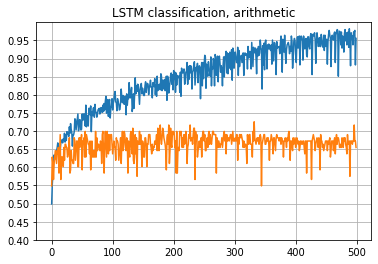

In [11]:
import matplotlib.pyplot as plt

print(history.history.keys())
fig, ax = plt.subplots(1)

ax.set_title("LSTM classification, arithmetic")
ax.set_ylim((0.4,1))
ax.set_yticks(np.arange(0.4,1,0.05))
ax.grid()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])

## Train Simple LSTM model


In [3]:
image_size = 32
frame_length = 1
sequence_length = 6
overlap = 0.5
num_classes = 2

In [4]:
dataPath = Path(r"C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiments3-Data\ArithmeticCalibrationProcedure\edf")
X_arith_seq, y_arith_seq = createImageDataset(dataPath,imageSize=image_size,frameDuration=frame_length,overlap=overlap,
                           image_format=False, augment_data=False, labels = ["EasyAdd","HardMult"],
                           lstm_format=True, lstm_sequence_length=sequence_length,
                           fileNameFormat=2)


file information: UJing 1 1 EasyAdd
file information: UJing 1 2 HardMult
file information: UJing 1 3 EasyAdd
file information: UJing 1 4 HardMult
file information: UJing 1 5 EasyAdd
file information: UJing 1 6 HardMult
file information: UJing 1 7 EasyAdd
file information: UJing 1 8 HardMult
file information: UJing 1 9 EasyAdd
file information: UJing 1 10 HardMult
file information: UJing 1 11 EasyAdd
file information: UJing 1 12 HardMult
file information: UJing 2 1 EasyAdd
file information: UJing 2 2 HardMult
file information: UJing 2 3 EasyAdd
file information: UJing 2 4 HardMult
file information: UJing 2 5 EasyAdd
file information: UJing 2 6 HardMult
file information: UJing 2 7 EasyAdd
file information: UJing 2 8 HardMult
file information: UJing 2 9 EasyAdd
file information: UJing 2 10 HardMult
file information: UJing 2 11 EasyAdd
file information: UJing 2 12 HardMult
file information: UJing 3 1 EasyAdd
file information: UJing 3 2 HardMult
file information: UJing 3 3 EasyAdd
file info

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_arith_seq, y_arith_seq, test_size=0.20,shuffle=True)

In [6]:
##Normalize the dataset

##No normalization -- Seems to yield the best results 
# x_train_2 = x_train
# x_test_2 = x_test

##Global frame/time normalization
global_mean = x_train.mean(); global_std = x_train.std();
x_train_2 = (x_train - global_mean)/global_std;
x_test_2 = (x_test - global_mean)/global_std;

## convert class vectors to binary class matrices
y_train_2 = keras.utils.to_categorical(y_train, num_classes)
y_test_2 = keras.utils.to_categorical(y_test, num_classes)

x_train_2 = x_train_2.astype('float32')
x_test_2 = x_test_2.astype('float32')

print(y_train.shape)
print(x_train.shape)

(451,)
(451, 6, 90)


In [7]:
##Training
batch_size = 128
num_classes = 2
epochs = 500
input_shape = (sequence_length,90)
model = createLstmModel(input_shape, num_classes)

history = model.fit(x_train_2, y_train_2,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_2, y_test_2),
          shuffle=True)

Train on 451 samples, validate on 113 samples
Epoch 1/500
128/451 [=======>......................] - ETA: 16s

InternalError:  Blas GEMM launch failed : a.shape=(768, 90), b.shape=(90, 64), m=768, n=64, k=90
	 [[node model/dense/Tensordot/MatMul (defined at <ipython-input-7-a57c89a920f8>:12) ]] [Op:__inference_distributed_function_11992]

Function call stack:
distributed_function


In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
fig, ax = plt.subplots(1)

ax.set_title("Simple LSTM classification, arithmetic")
ax.set_ylim((0.4,1))
ax.set_yticks(np.arange(0.4,1,0.05))
ax.grid()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])

## Train model with encoded features

In [21]:
img_size = 32
frame_duration = 1
overlap = 0.5
lstm_length = 5
autoencoder = keras.models.load_model('autoEncoderWeights/autoencoder.h5')
encoder = autoencoder.layers[1]

dataPath = Path(r"C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiments3-Data\ArithmeticCalibrationProcedure\edf")
X_arithm_encoded, y_arithm_encoded = createImageDataset(dataPath, imageSize=img_size,frameDuration=frame_duration,overlap=overlap,
                                      image_format=True, augment_data=False, labels = ["EasyAdd","HardMult"],
                                      encoded_format=True, autoencoder=encoder,lstm_format=True, lstm_sequence_length=lstm_length,
                                      fileNameFormat=2)

file information: UJing 1 1 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 2 HardMult
60 frames generated with label  1.0/60
file information: UJing 1 3 EasyAdd
Interpolating 60/60Interpolating 31/6060 frames generated with label  0.0
file information: UJing 1 4 HardMult
60 frames generated with label  1.0/60
file information: UJing 1 5 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 6 HardMult
60 frames generated with label  1.0/60Interpolating 51/60
file information: UJing 1 7 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 8 HardMult
60 frames generated with label  1.0/60
file information: UJing 1 9 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 10 HardMult
Interpolating 60/60Interpolating 30/6060 frames generated with label  1.0
file information: UJing 1 11 EasyAdd
60 frames generated with label  0.0/60
file information: UJing 1 12 HardMult
60 frames generated with label  1.0/60
fi

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X_arithm_encoded, y_arithm_encoded, test_size=0.20,shuffle=True)
print(X_arithm_encoded.shape)
print(x_train.shape)

(684, 5, 512)
(547, 5, 512)


In [23]:
##Global frame/time normalization
global_mean = x_train.mean(); global_std = x_train.std();
x_train_2 = (x_train - global_mean)/global_std;
x_test_2 = (x_test - global_mean)/global_std;

## convert class vectors to binary class matrices
y_train_2 = keras.utils.to_categorical(y_train, 2)
y_test_2 = keras.utils.to_categorical(y_test, 2)

x_train_2 = x_train_2.astype('float32')
x_test_2 = x_test_2.astype('float32')

print(y_train.shape)
print(x_train.shape)

(547,)
(547, 5, 512)


In [34]:
def createLstmModel(input_shape,num_classes, lstmLayers=2, lstmOutputSize=4.0,
                  isBidirectional=1.0, inputLayerNeurons=64, inputLayerDropout=0.25):

    dropoutRate = 0.45
    
    lstmLayers = int(lstmLayers)
    lstmOutputSize =int(lstmOutputSize)
    isBidirectional =int(isBidirectional)

    # Input layer
    networkInput = Input(shape=input_shape)
    dropout1 = Dropout(rate=inputLayerDropout)(networkInput)

    # First Hidden layer
    hidden1 = Dense(inputLayerNeurons, activation='relu')(dropout1)
    dropout2 = Dropout(rate=dropoutRate)(hidden1)
    batchNorm1 = BatchNormalization()(dropout2)

    out = batchNorm1
    for i in range(1, lstmLayers+1):
        retSeq = False if i == lstmLayers else True
        lstmLayer = LSTM(lstmOutputSize, stateful=False, return_sequences=retSeq,
                         dropout=dropoutRate, kernel_regularizer=regularizers.l2(0.05))
        if isBidirectional:
            out = Bidirectional(lstmLayer, merge_mode='concat')(out)
        else:
            out = lstmLayer(out)

    hidden3 = Dense(num_classes, activation='linear')(out)
    networkOutput = Softmax()(hidden3)

    model1 = Model(inputs=networkInput, outputs=networkOutput)
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model1

lstmModel = createLstmModel(x_train_2.shape[1:], 2)
lstmModel.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5, 512)]          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 512)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 5, 64)             32832     
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 64)             256       
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 5, 8)              2208      
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 8)                 416 

In [36]:
##Training
batch_size = 128
num_classes = 2
epochs = 500


history = lstmModel.fit(x_train_2, y_train_2,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_2, y_test_2),
          shuffle=True)

Train on 547 samples, validate on 137 samples
Epoch 1/500
547/547 [==============================] - 8s 15ms/sample - loss: 4.3502 - accuracy: 0.5338 - val_loss: 4.2311 - val_accuracy: 0.5328
Epoch 2/500
547/547 [==============================] - 0s 170us/sample - loss: 4.1782 - accuracy: 0.5082 - val_loss: 4.0668 - val_accuracy: 0.5328
Epoch 3/500
547/547 [==============================] - 0s 174us/sample - loss: 4.0165 - accuracy: 0.5210 - val_loss: 3.9059 - val_accuracy: 0.5255
Epoch 4/500
547/547 [==============================] - 0s 166us/sample - loss: 3.8624 - accuracy: 0.5320 - val_loss: 3.7503 - val_accuracy: 0.5474
Epoch 5/500
547/547 [==============================] - 0s 166us/sample - loss: 3.7129 - accuracy: 0.5338 - val_loss: 3.6022 - val_accuracy: 0.5693
Epoch 6/500
547/547 [==============================] - 0s 168us/sample - loss: 3.5711 - accuracy: 0.5155 - val_loss: 3.4613 - val_accuracy: 0.5620
Epoch 7/500
547/547 [==============================] - 0s 166us/sample - 

547/547 [==============================] - 0s 167us/sample - loss: 0.8503 - accuracy: 0.7002 - val_loss: 0.8435 - val_accuracy: 0.6642
Epoch 57/500
547/547 [==============================] - 0s 165us/sample - loss: 0.8385 - accuracy: 0.6910 - val_loss: 0.8284 - val_accuracy: 0.6861
Epoch 58/500
547/547 [==============================] - 0s 166us/sample - loss: 0.8078 - accuracy: 0.7075 - val_loss: 0.8151 - val_accuracy: 0.7007
Epoch 59/500
547/547 [==============================] - 0s 170us/sample - loss: 0.8093 - accuracy: 0.7057 - val_loss: 0.8004 - val_accuracy: 0.6715
Epoch 60/500
547/547 [==============================] - 0s 165us/sample - loss: 0.8063 - accuracy: 0.7093 - val_loss: 0.7877 - val_accuracy: 0.7080
Epoch 61/500
547/547 [==============================] - 0s 163us/sample - loss: 0.7814 - accuracy: 0.7093 - val_loss: 0.7920 - val_accuracy: 0.6496
Epoch 62/500
547/547 [==============================] - 0s 165us/sample - loss: 0.7843 - accuracy: 0.6929 - val_loss: 0.7965 

547/547 [==============================] - 0s 174us/sample - loss: 0.5479 - accuracy: 0.7514 - val_loss: 0.5705 - val_accuracy: 0.7299
Epoch 112/500
547/547 [==============================] - 0s 167us/sample - loss: 0.5613 - accuracy: 0.7404 - val_loss: 0.5736 - val_accuracy: 0.7299
Epoch 113/500
547/547 [==============================] - 0s 172us/sample - loss: 0.5768 - accuracy: 0.7514 - val_loss: 0.5735 - val_accuracy: 0.7153
Epoch 114/500
547/547 [==============================] - 0s 168us/sample - loss: 0.5764 - accuracy: 0.7386 - val_loss: 0.5721 - val_accuracy: 0.7226
Epoch 115/500
547/547 [==============================] - 0s 161us/sample - loss: 0.5629 - accuracy: 0.7386 - val_loss: 0.5694 - val_accuracy: 0.7299
Epoch 116/500
547/547 [==============================] - 0s 172us/sample - loss: 0.5609 - accuracy: 0.7404 - val_loss: 0.5938 - val_accuracy: 0.7153
Epoch 117/500
547/547 [==============================] - 0s 166us/sample - loss: 0.5573 - accuracy: 0.7349 - val_loss: 0

547/547 [==============================] - 0s 167us/sample - loss: 0.5395 - accuracy: 0.7404 - val_loss: 0.5683 - val_accuracy: 0.7299
Epoch 167/500
547/547 [==============================] - 0s 165us/sample - loss: 0.5396 - accuracy: 0.7477 - val_loss: 0.5861 - val_accuracy: 0.7153
Epoch 168/500
547/547 [==============================] - 0s 172us/sample - loss: 0.5233 - accuracy: 0.7441 - val_loss: 0.5636 - val_accuracy: 0.7299
Epoch 169/500
547/547 [==============================] - 0s 170us/sample - loss: 0.4977 - accuracy: 0.7550 - val_loss: 0.5410 - val_accuracy: 0.7299
Epoch 170/500
547/547 [==============================] - 0s 166us/sample - loss: 0.5282 - accuracy: 0.7495 - val_loss: 0.5427 - val_accuracy: 0.7372
Epoch 171/500
547/547 [==============================] - 0s 174us/sample - loss: 0.5005 - accuracy: 0.7715 - val_loss: 0.5639 - val_accuracy: 0.7445
Epoch 172/500
547/547 [==============================] - 0s 168us/sample - loss: 0.5108 - accuracy: 0.7386 - val_loss: 0

547/547 [==============================] - 0s 159us/sample - loss: 0.4993 - accuracy: 0.7532 - val_loss: 0.5512 - val_accuracy: 0.7372
Epoch 222/500
547/547 [==============================] - 0s 165us/sample - loss: 0.5216 - accuracy: 0.7514 - val_loss: 0.5473 - val_accuracy: 0.7153
Epoch 223/500
547/547 [==============================] - 0s 155us/sample - loss: 0.5047 - accuracy: 0.7733 - val_loss: 0.5527 - val_accuracy: 0.7226
Epoch 224/500
547/547 [==============================] - 0s 165us/sample - loss: 0.5321 - accuracy: 0.7441 - val_loss: 0.5676 - val_accuracy: 0.7080
Epoch 225/500
547/547 [==============================] - 0s 161us/sample - loss: 0.5015 - accuracy: 0.7587 - val_loss: 0.5783 - val_accuracy: 0.6934
Epoch 226/500
547/547 [==============================] - 0s 163us/sample - loss: 0.5201 - accuracy: 0.7495 - val_loss: 0.5854 - val_accuracy: 0.6934
Epoch 227/500
547/547 [==============================] - 0s 154us/sample - loss: 0.4863 - accuracy: 0.7861 - val_loss: 0

547/547 [==============================] - 0s 165us/sample - loss: 0.4918 - accuracy: 0.7550 - val_loss: 0.5454 - val_accuracy: 0.7299
Epoch 277/500
547/547 [==============================] - 0s 165us/sample - loss: 0.4903 - accuracy: 0.7678 - val_loss: 0.5463 - val_accuracy: 0.7299
Epoch 278/500
547/547 [==============================] - 0s 163us/sample - loss: 0.4583 - accuracy: 0.8080 - val_loss: 0.5622 - val_accuracy: 0.7153
Epoch 279/500
547/547 [==============================] - 0s 167us/sample - loss: 0.4681 - accuracy: 0.7806 - val_loss: 0.5745 - val_accuracy: 0.7299
Epoch 280/500
547/547 [==============================] - 0s 166us/sample - loss: 0.4720 - accuracy: 0.7861 - val_loss: 0.5785 - val_accuracy: 0.7080
Epoch 281/500
547/547 [==============================] - 0s 165us/sample - loss: 0.4667 - accuracy: 0.7806 - val_loss: 0.5905 - val_accuracy: 0.7080
Epoch 282/500
547/547 [==============================] - 0s 168us/sample - loss: 0.4911 - accuracy: 0.7751 - val_loss: 0

547/547 [==============================] - 0s 168us/sample - loss: 0.4747 - accuracy: 0.7678 - val_loss: 0.5598 - val_accuracy: 0.7226
Epoch 332/500
547/547 [==============================] - 0s 168us/sample - loss: 0.4925 - accuracy: 0.7642 - val_loss: 0.5634 - val_accuracy: 0.7153
Epoch 333/500
547/547 [==============================] - 0s 166us/sample - loss: 0.5028 - accuracy: 0.7751 - val_loss: 0.5696 - val_accuracy: 0.7080
Epoch 334/500
547/547 [==============================] - 0s 166us/sample - loss: 0.4895 - accuracy: 0.7642 - val_loss: 0.5698 - val_accuracy: 0.6861
Epoch 335/500
547/547 [==============================] - 0s 171us/sample - loss: 0.4855 - accuracy: 0.7697 - val_loss: 0.5720 - val_accuracy: 0.6934
Epoch 336/500
547/547 [==============================] - 0s 168us/sample - loss: 0.5023 - accuracy: 0.7422 - val_loss: 0.5744 - val_accuracy: 0.7007
Epoch 337/500
547/547 [==============================] - 0s 168us/sample - loss: 0.4666 - accuracy: 0.7843 - val_loss: 0

547/547 [==============================] - 0s 166us/sample - loss: 0.4707 - accuracy: 0.7806 - val_loss: 0.5931 - val_accuracy: 0.6642
Epoch 387/500
547/547 [==============================] - 0s 170us/sample - loss: 0.4674 - accuracy: 0.7916 - val_loss: 0.5861 - val_accuracy: 0.7226
Epoch 388/500
547/547 [==============================] - 0s 166us/sample - loss: 0.4751 - accuracy: 0.7788 - val_loss: 0.5959 - val_accuracy: 0.7299
Epoch 389/500
547/547 [==============================] - 0s 163us/sample - loss: 0.4728 - accuracy: 0.7587 - val_loss: 0.5819 - val_accuracy: 0.7153
Epoch 390/500
547/547 [==============================] - 0s 170us/sample - loss: 0.4821 - accuracy: 0.7843 - val_loss: 0.5845 - val_accuracy: 0.6788
Epoch 391/500
547/547 [==============================] - 0s 172us/sample - loss: 0.4855 - accuracy: 0.7806 - val_loss: 0.5751 - val_accuracy: 0.6934
Epoch 392/500
547/547 [==============================] - 0s 164us/sample - loss: 0.5027 - accuracy: 0.7770 - val_loss: 0

547/547 [==============================] - 0s 167us/sample - loss: 0.4527 - accuracy: 0.7916 - val_loss: 0.5555 - val_accuracy: 0.6934
Epoch 442/500
547/547 [==============================] - 0s 165us/sample - loss: 0.4350 - accuracy: 0.7971 - val_loss: 0.5575 - val_accuracy: 0.6861
Epoch 443/500
547/547 [==============================] - 0s 166us/sample - loss: 0.4305 - accuracy: 0.8044 - val_loss: 0.5721 - val_accuracy: 0.7007
Epoch 444/500
547/547 [==============================] - 0s 168us/sample - loss: 0.4503 - accuracy: 0.8044 - val_loss: 0.5857 - val_accuracy: 0.7372
Epoch 445/500
547/547 [==============================] - 0s 170us/sample - loss: 0.4681 - accuracy: 0.7751 - val_loss: 0.6178 - val_accuracy: 0.7080
Epoch 446/500
547/547 [==============================] - 0s 166us/sample - loss: 0.4495 - accuracy: 0.8062 - val_loss: 0.6375 - val_accuracy: 0.6861
Epoch 447/500
547/547 [==============================] - 0s 169us/sample - loss: 0.4972 - accuracy: 0.7751 - val_loss: 0

547/547 [==============================] - 0s 168us/sample - loss: 0.4446 - accuracy: 0.7898 - val_loss: 0.5819 - val_accuracy: 0.7591
Epoch 497/500
547/547 [==============================] - 0s 170us/sample - loss: 0.4383 - accuracy: 0.8080 - val_loss: 0.5845 - val_accuracy: 0.7591
Epoch 498/500
547/547 [==============================] - 0s 166us/sample - loss: 0.4611 - accuracy: 0.7879 - val_loss: 0.5812 - val_accuracy: 0.7372
Epoch 499/500
547/547 [==============================] - 0s 170us/sample - loss: 0.4518 - accuracy: 0.8007 - val_loss: 0.6135 - val_accuracy: 0.6861
Epoch 500/500
547/547 [==============================] - 0s 168us/sample - loss: 0.4658 - accuracy: 0.7806 - val_loss: 0.6242 - val_accuracy: 0.6569


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


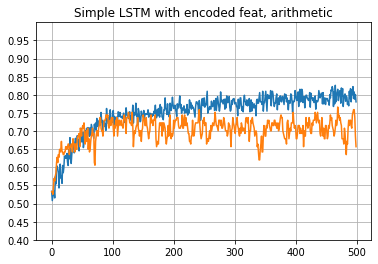

In [37]:
import matplotlib.pyplot as plt

print(history.history.keys())
fig, ax = plt.subplots(1)

ax.set_title("Simple LSTM with encoded feat, arithmetic")
ax.set_ylim((0.4,1))
ax.set_yticks(np.arange(0.4,1,0.05))
ax.grid()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])